In [230]:
import numpy as np
import pandas as pd
import scipy as scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pydissertation import Model, BasketOption, pde_pricer

In [231]:
PDE_STEP_COUNT = 50
IMPLIED_VOLATILITY_TOLERANCE = 0.0001

In [232]:
def black_scholes_formula(model, option, volatiliy):
    initial_basket_value = np.dot(np.array(option.weights), np.array(model.initial_prices))
    stdnorm = scipy.stats.norm(0,1)
    discounting_factor = np.exp(-r * option.expiry_time)
    dminus = (np.log(initial_basket_value / option.strike_price) + (r - volatiliy ** 2 / 2) * option.expiry_time) / (volatiliy * np.sqrt(option.expiry_time))
    dplus = (np.log(initial_basket_value / option.strike_price) + (r + volatiliy ** 2 / 2) * option.expiry_time) / (volatiliy * np.sqrt(option.expiry_time))
    return initial_basket_value * stdnorm.cdf(dplus) - option.strike_price * discounting_factor * stdnorm.cdf(dminus)

def implied_volatility(model, option, price):
    def err(volatility):
        return (black_scholes_formula(model, option, volatility) - price) ** 2
    return scipy.optimize.minimize_scalar(err, bracket=(0.01,1), tol=IMPLIED_VOLATILITY_TOLERANCE).x

def implied_volatility_from_strike_price(model, weights, expiry_time):
    df = pd.DataFrame(columns=["strike_price"], data=np.arange(100,300,5))
    df["option"] = df.apply(
        lambda row: BasketOption(weights=weights, expiry_time=expiry_time, strike_price=row["strike_price"]),
        axis=1)
    df["option_price"] = df.apply(
        lambda row: pde_pricer(PDE_STEP_COUNT, model, row["option"]),
        axis=1)
    df["implied_volatility"] = df.apply(
        lambda row: implied_volatility(model, row["option"], row["option_price"]),
        axis=1)
    return df

def implied_volatility_from_expiry_time(model, weights, strike_price):
    df = pd.DataFrame(columns=["expiry_time"], data=np.arange(0.1,1,0.025))
    df["option"] = df.apply(
        lambda row: BasketOption(weights=weights, expiry_time=row["expiry_time"], strike_price=strike_price),
        axis=1)
    df["option_price"] = df.apply(
        lambda row: pde_pricer(PDE_STEP_COUNT, model, row["option"]),
        axis=1)
    df["implied_volatility"] = df.apply(
        lambda row: implied_volatility(model, row["option"], row["option_price"]),
        axis=1)
    return df


In [233]:
def target_vol_strike(x):
    return 0.00001 * (x-200) ** 2 + 0.25

def target_vol_expiry(t):
    return 0.5 * (t-0.5) ** 2 + 0.25

def make_model(params):
    def volatility(t):
        tl = params[0] + params[1] * t + params[2] * t ** 2
        tr = params[3] + params[4] * t + params[5] * t ** 2
        bl = params[6] + params[7] * t + params[8] * t ** 2
        br = params[9] + params[10] * t + params[11] * t ** 2
        return [[tl, tr], [bl, br]]
    return Model(initial_prices=[100,50], volatility=volatility, riskfree_rate=lambda t: 0.02)

def individual_error(x, y):
    return np.maximum(0, (x - y) ** 2 - IMPLIED_VOLATILITY_TOLERANCE)

def cost_strike_price(params):
    model = make_model(params)
    imp_vol_strike_prices = implied_volatility_from_strike_price(model, weights=[1,2], expiry_time=1)
    imp_vol_strike_prices["target"] = imp_vol_strike_prices.apply(
        lambda row: target_vol_strike(row["strike_price"]),
        axis=1)
    errs = individual_error(imp_vol_strike_prices["target"], imp_vol_strike_prices["implied_volatility"])
    return errs.sum()

def cost_expiry_time(params):
    model = make_model(params)
    imp_vol_expiry_times = implied_volatility_from_expiry_time(model, weights=[1,2], strike_price=200)
    imp_vol_expiry_times["target"] = imp_vol_expiry_times.apply(
        lambda row: target_vol_expiry(row["expiry_time"]),
        axis=1)
    errs = individual_error(imp_vol_expiry_times["target"], imp_vol_expiry_times["implied_volatility"])
    return errs.sum()

def optimise_model(cost):
    initial_params = [0.1] * 12
    bounds = [(-2, 2)] * 12
    return scipy.optimize.minimize(
        cost,
        initial_params,
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter":100},
    ).x

In [237]:
model_strike_price_params = optimise_model(cost_strike_price)
model_strike_price = make_model(model_strike_price_params)
model_strike_price_params

array([0.09602542, 0.09769999, 0.09835812, 0.09602542, 0.09769999,
       0.09835812, 0.09602542, 0.0977    , 0.09835813, 0.09602542,
       0.0977    , 0.09835813])

In [235]:
model_expiry_time_params = optimise_model(cost_expiry_time)
model_expiry_time = make_model(model_expiry_time_params)
model_expiry_time_params

array([ 0.15353583, -0.5099269 ,  1.09751523,  0.15353616, -0.50993223,
        1.09751673,  0.40895467, -1.00623277,  0.97283087,  0.40895659,
       -1.0062341 ,  0.97283866])

[]

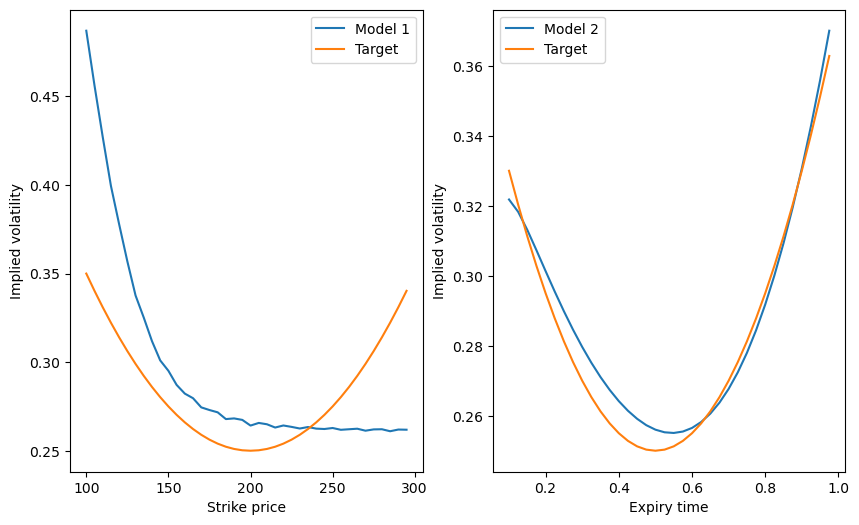

In [245]:
imp_vol_strike_prices = implied_volatility_from_strike_price(model_strike_price, weights=[1,2], expiry_time=1)
imp_vol_strike_prices["target"] = imp_vol_strike_prices.apply(
    lambda row: target_vol_strike(row["strike_price"]),
    axis=1)
imp_vol_expiry_times = implied_volatility_from_expiry_time(model_expiry_time, weights=[1,2], strike_price=200)
imp_vol_expiry_times["target"] = imp_vol_expiry_times.apply(
    lambda row: target_vol_expiry(row["expiry_time"]),
    axis=1)

fig, axs = plt.subplots(ncols=2, figsize=(10,6))
sns.lineplot(data=imp_vol_strike_prices, x="strike_price", y="implied_volatility", ax=axs[0], label="Model 1")
sns.lineplot(data=imp_vol_strike_prices, x="strike_price", y="target", ax=axs[0], label="Target")
axs[0].set(xlabel="Strike price", ylabel="Implied volatility")
sns.lineplot(data=imp_vol_expiry_times, x="expiry_time", y="implied_volatility", ax=axs[1], label="Model 2")
sns.lineplot(data=imp_vol_expiry_times, x="expiry_time", y="target", ax=axs[1], label="Target")
axs[1].set(xlabel="Expiry time", ylabel="Implied volatility")
plt.savefig("graphs/fitted_models.png")
plt.plot()